I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track of their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insights on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install praw duckdb jupysql bertopic groq pyabsa tqdm --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import os
from pprint import pprint
from tqdm import trange, tqdm, tqdm_notebook # progress bar for run time >30 min

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 
from math import pi
import plotly.express as px

# Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

# Named Entity Recognition
import spacy 
import requests 
from bs4 import BeautifulSoup
nlp = spacy.load("en_core_web_sm")
pd.set_option("display.max_rows", 200)

from spacy import displacy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-07-13 18:14:22.155826: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 18:14:22.155984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 18:14:22.341456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-13 18:15:07] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# YouTube and Reddit Data

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [4]:
user_secrets = UserSecretsClient()

In [5]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [6]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [7]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

,author,published_at,like_count,text,video_id
9144,@awspas,2024-06-11T07:51:14Z,0,in mkbhd we trust ✋🏻,qkYoBNdcXBU
3459,@snyzerxryzen,2024-06-11T18:03:27Z,12,"bro ,your humble 2:40 request stopped me from doing it 😂😂",qkYoBNdcXBU
104,@Matt-ut6ek,2024-06-22T16:14:07Z,0,Math notes is so cheating lol I wish I had it for college much less 6th grade lol,qkYoBNdcXBU
4614,@tejaswivemulapati287,2024-06-11T14:58:34Z,0,"Apple be pullin up to the AI scene with ""ClosedAI"" lmao",qkYoBNdcXBU
2881,@philippk5114,2024-06-11T20:18:04Z,0,und er hat sogar die DB Navigator App😂😂,qkYoBNdcXBU


In [8]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [9]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

,author,published_at,like_count,text,youtube_channel,published_at_date,published_at_month
6468,@thecsslife,2024-06-11 11:23:11,0,"If AI can make Siri better that would be great, but I'm very skeptical so far. It's mostly a gimmick.",MKBHD,2024-06-11,6
5976,@sackville_bagginsess,2024-06-11 12:22:12,0,"They'll need to add ""don't ask me again"" or ""don't ask for me 7 days""",MKBHD,2024-06-11,6
3049,@LIMITEDDAYS,2024-06-11 19:36:21,0,FYI Zipper says: 끈임없는 추구: endless pursuit,MKBHD,2024-06-11,6
5876,@CuteSkyler,2024-06-11 12:34:03,1,Do people *actually* want to hear about AI? Really?,MKBHD,2024-06-11,6
998,@ubr7772,2024-06-12 23:25:53,0,Yebsan shu joyiga,MKBHD,2024-06-12,6


In [10]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9823
The Verge     483
Name: count, dtype: int64

In [11]:
df0['app'] = 'YouTube'

In [12]:
len(df0)

10306

In [13]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [14]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [15]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [16]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [17]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         812   
1                   6         530   
2                   6         878   
3                   6         133   
4                   6          89   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [18]:
len(reddit_df)

1343

In [19]:
reddit_df['app'] = 'Reddit'

In [20]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [21]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [22]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [23]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11649

In [24]:
df.head()

,author,published_at,like_count,text,published_at_date,published_at_month,app
0,@dejayy8992,2024-07-13 17:45:52,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,7,YouTube
1,@srmtravel,2024-07-13 08:52:09,0,Can we tag faces with names?,2024-07-13,7,YouTube
2,@matt.rentfro,2024-07-13 04:55:23,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,7,YouTube
3,@tommys_version,2024-07-13 02:44:14,0,iOS 18: The everybody else's features update,2024-07-13,7,YouTube
4,@jonaspadberg7385,2024-07-11 21:58:34,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,7,YouTube


____
# Data Augmentation with Synonyms 
Future use. It was not used here given Groq's limitations and sufficient conclusions given volume of data retrieved.

In [25]:
# If there is not enough data, augment data with synonyms. 
# (This was explored since Groq API had issues with >100 predictons at one time.) 
# However, the code is below just in case it is needed in the future for better model training and therefore prediction. 
# At the same time, picking a model that understands variance in data is another approach at high inference accuracy.

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def replace_with_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            new_text.append(synonyms[0])  # Replace with the first synonym
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Load a pre-trained model for masked language modeling
unmasker = pipeline('fill-mask', model='bert-base-uncased')

def replace_with_contextual_synonyms(text):
    words = text.split()
    new_text = []
    for word in words:
        if wordnet.synsets(word):  # Check if word has synonyms
            masked_text = text.replace(word, '[MASK]', 1)
            suggestions = unmasker(masked_text)
            best_synonym = suggestions[0]['token_str']  # Get the best synonym
            new_text.append(best_synonym)
        else:
            new_text.append(word)
    return ' '.join(new_text)

# Test the functions
sample_text = "The quick brown fox jumps over the lazy dog."

# Basic synonym replacement
augmented_text = replace_with_synonyms(sample_text)
print("Basic Synonym Replacement:", augmented_text)

# Contextual synonym replacement
contextual_augmented_text = replace_with_contextual_synonyms(sample_text)
print("Contextual Synonym Replacement:", contextual_augmented_text)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1107: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/lexnames'>
  for i, line in enumerate(self.open('lexnames')):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adj'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.adv'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordnet.py:1159: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/wordnet/index.noun'>
  for i, line in enumerate(self.open('index.%s' % suffix)):
/opt/conda/lib/python3.10/site-packages/n

Basic Synonym Replacement: The speedy chocolate-brown bedevil parachute o'er the indolent dog.
Contextual Synonym Replacement: The little thinking cat watched at the little dog.


Both are not that great because these sentences would not be used in real life. I would use Groq again in order to have better quality synonyms. 

In [26]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            I am trying to test out some data augmentation methods using word replacement with synonyms. 
            Given this sentence, please create an alternative or alternatives, but similar sentence using synonyms:
            The quick brown fox jumps over the lazy dog.
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

'What a classic sentence!\n\nI\'d be happy to help you come up with some alternatives using word replacement with synonyms. Here are a few examples:\n\n1. **The swift reddish fox leaps over the indolent canine.**\n\t* Replaced "quick" with "swift", "brown" with "reddish", "jumps" with "leaps", and "lazy" with "indolent".\n2. **The rapid auburn fox springs over the sluggish hound.**\n\t* Replaced "quick" with "rapid", "brown" with "auburn", "jumps" with "springs", and "dog" with "hound".\n3. **The swift tawny fox bounds over the lethargic pup.**\n\t* Replaced "quick" with "swift", "brown" with "tawny", "jumps" with "bounds", and "dog" with "pup".\n\nLet me know if you\'d like me to generate more alternatives!'

Awesome, just as I predicted, LLM is much better than NLTK algorithms. :)
____

# BERTopic Modeling

In [27]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-13 18:21:40,787 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-07-13 18:23:29,175 - BERTopic - Embedding - Completed ✓
2024-07-13 18:23:29,177 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-13 18:24:11,013 - BERTopic - Dimensionality - Completed ✓
2024-07-13 18:24:11,016 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-13 18:24:22,425 - BERTopic - Cluster - Completed ✓
2024-07-13 18:24:22,435 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-13 18:24:41,993 - BERTopic - Representation - Completed ✓


Topic  Count                                                  Name  \
0       -1   2770                             -1_ai_apple_features_just   
1        0   1002                   0_calculator_ipad_handwriting_maths   
2        1    548                       1_apple_stock_products_features   
3        2    468                    2_siri_type_accessibility_settings   
4        3    273                              3_ai_times_ml_definition   
5        4    262                         4_android_ios_features_switch   
6        5    256                            5_icons_change_colors_ugly   
7        6    200                            6_s24_ultra_reading_galaxy   
8        7    187                         7_apple_hardware_copying_just   
9        8    187                         8_ios18_beta_update_jailbreak   
10       9    182                          9_tinder_grindr_wives_folder   
11      10    182                          10_ai_apple_marketing_genius   
12      11    168                                       11_11_07_воу_55   
13      12    155                                  12_ipad_pro_power_m4   
14      13    153                   13_intelligence_apple_cringe_insult   
15      14    149                         14_privacy_data_cloud_compute   
16      15    128                               15_15_pro_plus_features   
17      16    119                        16_homescreen_ruin_ugly_design   
18      17    118                            17_pro_14_obsolete_battery   
19      18    115                         18_emojis_robber_generate_hat   
20      19     98                                    19_pro_15_m1_apple   
21      20     98                 20_mirroring_iphone_huawei_continuity   
22      21     97                               21_openai_elon_musk_llm   
23      22     93                    22_lighting_grading_sunset_setting   
24      23     92                      23_yo_zzzzzzzz_coryxkenshin_yess   
25      24     85                           24_script_note_wwdc_android   
26      25     81                           25_vr_announced_3d_visionos   
27      26     74                         26_chatgpt_4o_integration_api   
28      27     73                    27_images_artists_generative_adobe   
29      28     72                             28_ai_apple_compete_trust   
30      29     71                      29_marques_samsung_reading_notes   
31      30     70                 30_conference_keynotes_platforms_fest   
32      31     68                         31_android_years_features_omg   
33      32     67                 32_samsung_talking_ngyjzqr_contrarian   
34      33     65   33_messages_scheduling_jerryrigeverything_shortcuts   
35      34     64                            34_mkbhd_light_studio_rush   
36      35     63                           35_video_brother_thank_love   
37      36     60                              36_db_bvg_bahn_transport   
38      37     60                      37_marques_pedro_brownlee_batman   
39      38     59                                    38_00_shine_fun_33   
40      39     57             39_customization_options_people_ringtones   
41      40     57             40_watched_endosym5023_length_impatiently   
42      41     55                   41_chapters_계선기_backgraund_apostasy   
43      42     55                42_chatgpt_gpt_confirming_subscription   
44      43     53                43_upgrade_supported_generations_14pro   
45      44     53                     44_genmojis_uncanny_stickers_send   
46      45     52           45_keyboard_unplug_autocorrect_accidentally   
47      46     50                          46_satellite_sms_garmin_wifi   
48      47     49                       47_watchos_garmin_fitness_goals   
49      48     48                48_congo_technology_inheritance_dumber   
50      49     48                    49_window_snapping_macos_rectangle   
51      50     48                     50_coming_verge_updates_wavelettt   
52      51     46             

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [28]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
# df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-13 18:31:33,795 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-13 18:31:46,355 - BERTopic - Dimensionality - Completed ✓
2024-07-13 18:31:46,359 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-13 18:31:54,616 - BERTopic - Cluster - Completed ✓
2024-07-13 18:31:54,626 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-13 18:32:11,112 - BERTopic - Representation - Completed ✓


CPU times: user 1min 54s, sys: 28.6 s, total: 2min 23s
Wall time: 1min 14s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4433,-1_apple_android_like_features,"[apple, android, like, features, ai, new, users, google, video, ios]","[What if you just want it to use GPT every time since it is better, Most of these features sounds like something Google already did for a long time., I'm really impressed by the continuity features, I'm most of the way into the Apple ecosystem, I use a personal Mac, iPad, Apple TV, and even a work iPhone (plus everyone else in my life has an iPhone so...) \n\nHowever, I've used an Android as my personal phone for nearly 15 years now, and do really enjoy android. And since the majority of the day I'm on my work PC, I like that it has always been a pretty good middle man between the Mac and Windows world. \n\nBut hot damn, just the iPhone Mirroring feature alone makes me think I'm finally going to make the switch to the iPhone side. And there's ton of other really impressive stuff they announced. \nGG Apple.]"
1,0,635,0_samsung_s24_ultra_notes,"[samsung, s24, ultra, notes, marques, mkbhd, updates, event, funny, ios]","[You are reading iOS features from Samsung Ultra 😉, Reading notes of a Samsung.., reading notes about apple on samsung😂😂]"
2,1,574,1_siri_type_accessibility_voice,"[siri, type, accessibility, voice, chatgpt, languages, bixby, feature, button, homepods]","[you could type to siri before as well, TYPE to siri has always been there, AI as in Siri?]"
3,2,462,2_15_iphone_ai_plus,"[15, iphone, ai, plus, upgrade, features, a17, m1, wait, base]","[iPhone 15 Pro only, *Only on the iPhone 15 Pro, Will we get AI in iphone 15 also or in 15 pro or pro max]"
4,3,349,3_icons_apps_ugly_widgets,"[icons, apps, ugly, widgets, homescreen, tint, theme, packs, moving, customize]","[I cannot wait to move my homescreen icons wherever I want on the screen :), I really want to know if i can keep the ""normal"" color icons when in dark mode. I hate how the black icons look, You couldn't move around the icons on the home screen on iPhone until 2024?]"
5,4,340,4_apple_intelligent_sounds_term,"[apple, intelligent, sounds, term, chatgpt, openai, cringe, rebranding, lol, shop]","[Apple Intelligence my a$$., ""Apple Intelligence"" 💀💀💀, Apple Intelligence… what’s next?]"
6,5,274,5_calculator_app_notes_equations,"[calculator, app, notes, equations, pencil, students, ipads, lol, graphs, robots]","[Finally iPad has a calculator, Calculator App to iPad. 😂😂, Calculator on iPad 😂❤]"
7,6,243,6_ai_news_times_ml,"[ai, news, times, ml, definition, communication, generative, world, said, smart]","[AI again?!, AI, Everything except for AI]"
8,7,218,7_shill_apples_sequoia_yada,"[shill, apples, sequoia, yada, នទ, lame, toyota, fool, promote, mathcad]","[well done Apple!, Apple ... what ?, Only apple can do...]"
9,8,202,8_android_years_apple_funny,"[android, years, apple, funny, copies, market, just, feature, boomer, fanboys]","[apple just became android 😂, I'm Android & Apple 😜, Apple becoming more of Android. 😜]"


In [29]:
topic_model.get_topic(0) # top topic

[('samsung', 0.10516706276361751),
 ('s24', 0.05291227939529005),
 ('ultra', 0.05187165255377964),
 ('notes', 0.03997242750085476),
 ('marques', 0.03110681939390982),
 ('mkbhd', 0.02986549692490343),
 ('updates', 0.020705925895937134),
 ('event', 0.016340274269026955),
 ('funny', 0.016068425991594342),
 ('ios', 0.014622632405820127)]

These topics seem more interpretable due to better embeddings. (Also, there was an index shift with topic 0 being non-outlier topic, but most popular topic.)

## BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [30]:
topic_model.visualize_topics()

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The biggest topic after the outlier topic was topic 0 centered on: samsung, s24, ultra, notes, marques (noise). I used the slider to move across topics. The highlighted bubble helps you see which topic you are examining. This is helpful if you cannot tell which topic you are on based on the slider ticks. When you hover over the bubble, you see the words associated with the topic.

In [31]:
topic_model.visualize_barchart(top_n_topics=8)

We see the top 8 topics and their associated words. The higher the score for a word, the more central it is to the topic. 

In order to get context to explain why these topics are popular, whether or not there is positive/negative sentiment tied to this, had to go to the reference_docs column. This gave me the comments tied to the topics.

Samsung24 Ultra Notes were mentioned only because an Apple presenter was using a competitor to present Apple's latest releases. So many people found this humorous. This would be noise if our goal is to determine what about Apple people liked/disliked.

Huge wins for Apple were announcing their AI integrations, but there was critique/mocking when it came to their Siri, icons and iPad calculator updates. There was bewilderment about whether or not the new features would be available on the base iPhone 15 model or just the Pro and Max versions. Looks like Apple needs to keep working on its brand because it got mixed reviews from its latest updates and future releases.

In [32]:
topic_model.visualize_heatmap()

Cosine Similarity Matrix: This is a table where each cell (i, j) contains the cosine similarity between the embedding of topic i and the embedding of topic j. If the value is close to 1, it means those topics are very similar. If it's close to 0, they are quite different.

Heatmap: This is a graphical representation of the cosine similarity matrix. In a heatmap, colors are used to represent values in the matrix. Typically, darker colors might represent higher similarity (values closer to 1), while lighter colors represent lower similarity (values closer to 0).

___

This Similarity Matrix would be nice if it was broken down into smaller matrices, but the number of possible combinations would be reduced. When hovering over the darkest squares there are some interesting similar topics that are far away in index number, but words within topics were similar. For example, two topics (35 and 66) crossing with similarity score of: 0.748841 have these words in their topics: (35): updates, underwhelming, biggest, ipadOS (66): updates, turning, ios7, wasteland. Similarity is in Apple's updates being disappointing. When looking at the reference doc's for each topic, reference comment for 66 was negative.

* Not sure what the benchmark is for good separation between topics. 
* Topics not along the diagonal are unique topics.
* Most topics are 0.4 or below in similarity score. This means there are nice separate topics discovered under better embeddings and BERTopic model.

# Perform Sentiment and Emotion Classification

In [33]:
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Long comments cause error in model inference because model has cap in total number of tokens as input. To get arround this, will use a tokenizer to determine total tokens per comment. Then will summarize those comments that exceed input max token count. Will use LLM to summarize 
long comments. Finally, before sentiment inference, filter will be used to retain comments that only are below threshold for max token count.

In [34]:
# Need to make comments text as similar as text was for model's training for sentiment inference: remove HTML tags
# Using cased model so case-sentitive text used to train model. So for new data input, no need for lowering text.

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

,author,published_at,like_count,text,published_at_date,published_at_month,app,processed_text
0,@dejayy8992,2024-07-13 17:45:52,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,7,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY"
1,@srmtravel,2024-07-13 08:52:09,0,Can we tag faces with names?,2024-07-13,7,YouTube,Can we tag faces with names?
2,@matt.rentfro,2024-07-13 04:55:23,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,7,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?
3,@tommys_version,2024-07-13 02:44:14,0,iOS 18: The everybody else's features update,2024-07-13,7,YouTube,iOS 18: The everybody else's features update
4,@jonaspadberg7385,2024-07-11 21:58:34,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,7,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D


In [35]:
%%time

# 1. Determine total tokens
# 2. Filter out comments that have max: 450 total tokens since tokenizer can add suffixes as a token. So buffering for that.
# 3. Summarize comments using Groq since losing richness of dataset if eliminated comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 2.6 s, sys: 5.74 ms, total: 2.61 s
Wall time: 2.69 s


,author,published_at,like_count,text,published_at_date,published_at_month,app,processed_text,num_tokens
0,@dejayy8992,2024-07-13 17:45:52,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,7,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",64
1,@srmtravel,2024-07-13 08:52:09,0,Can we tag faces with names?,2024-07-13,7,YouTube,Can we tag faces with names?,7
2,@matt.rentfro,2024-07-13 04:55:23,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,7,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?,20
3,@tommys_version,2024-07-13 02:44:14,0,iOS 18: The everybody else's features update,2024-07-13,7,YouTube,iOS 18: The everybody else's features update,10
4,@jonaspadberg7385,2024-07-11 21:58:34,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,7,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,22


In [36]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [37]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [38]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [39]:
# Testing
 
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Thank you for your kind words about my videos! I'm glad you appreciate my approach to sharing tech news in a clear and concise manner. I'm always looking for ways to improve and appreciate your suggestion. As a software engineer who's passionate about learning, I'm intrigued by your idea of creating a real tech news channel.\n\nYou suggest joining forces with other tech experts, like Brian Tong and some from Engadget, to create a 24/7 news channel that covers tech news daily, rather than just breaking stories. This channel would focus on in-depth reporting, interviews with tech CEOs, and even investigations into the sometimes-influential tech companies.\n\nI agree that politics and tech are increasingly colliding, and a news channel dedicated to tech could play a crucial role in holding companies accountable. Your idea could be a game-changer, and I'm excited to learn more about it. I'd love to discuss the possibility of working together as a producer or collaborator. Thank you for sh

In [40]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[0]

"Thank you for your kind words about my videos! I'm glad you appreciate my approach to sharing tech news in a clear and concise manner. I'm always looking for ways to improve and appreciate your suggestion. As a software engineer who's passionate about learning, I'm intrigued by your idea of creating a real tech news channel."

In [41]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[0]))

70

* [x] Now write up a function in order to loop through Pandas text column that has > 450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has <= 450 tokens
* [x] After verification, perform sentiment and emotion analysis using HF and Groq

In [42]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

In [43]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [44]:
condensed[1]

"The new iPad calculator app is just a gimmick. It's being hailed for its ability to give answers as you write down a math question, but this feature is only useful up to 4th grade. Math exams require showing work and doing mental arithmetic, making a physical calculator much more practical. The app's AI-powered features are no match for dedicated calculators that can solve integrals, graph functions, and more. In fact, the TI-Nspire calculator is a better and more powerful tool for advanced math. The app's novelty and design make it appealing, but it can't replace the functionality of a physical calculator.\n\nThe app's other features, such as adjusting numbers for new answers and adding graphs, can be replicated with existing software like Geogebra and Desmos. These free and more powerful alternatives make the iPad calculator app seem like a waste of money. It's all about prioritizing real-world usefulness over engineering complexity and marketing hype."

In [45]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of > 450 token comment. Now let us make two lists into two Pandas columns. And then join this to the original df on the non-condensed text. This will create a df that has the original >= 450 tokens comments and the condensed version of long comments.

In [46]:
summarize_df['condensed_text'] = condensed

In [47]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [48]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",None
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?,None
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?,None
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,iOS 18: The everybody else's features update,None
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,None


In [49]:
#Checking that the join outputs same number of rows as original df
len(summarized_df)

11649

In [50]:
summarized_df.head(1)

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",None


In [51]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1) # taking care of Groq API residue
inf_df.head(5)

,author,like_count,original_text,published_at_date,app,final_text
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY"
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,iOS 18: The everybody else's features update
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D


In [52]:
inf_df.isnull().sum()

author               44
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [53]:
# Checking that comments that got condensed show up instead of original lengthy comment
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger         100   
2     hammerheadtiger          10   
3     hammerheadtiger           5   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         878   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Now let us re-tokenize the text to make sure we don't hit an error. 

In [54]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [55]:
query = """
select max(num_tokens) as max_tokens
from inf_df
"""
duckdb.query(query).df()

,max_tokens
0,446


In [56]:
# If the sentiment classifier still has comments that exceed 512 tokens then need to summarize more comments.
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [57]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

,author,like_count,original_text,published_at_date,app,final_text
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY"


Great! Let us now perform sentiment and emotion classifications.

In [58]:
len(inf_df)-len(inf_df2) # Difference is small. So proceed.

0

## Sentiment Classification

In [59]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 18min 12s, sys: 3.47 s, total: 18min 16s
Wall time: 9min 8s


,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",64,"[{'label': 'negative', 'score': 0.8093844652175903}]",negative,0.809384
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?,7,"[{'label': 'negative', 'score': 0.40420642495155334}]",negative,0.404206
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?,20,"[{'label': 'negative', 'score': 0.4331153333187103}]",negative,0.433115
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,iOS 18: The everybody else's features update,10,"[{'label': 'positive', 'score': 0.4815760552883148}]",positive,0.481576
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,22,"[{'label': 'positive', 'score': 0.6226241588592529}]",positive,0.622624


In [60]:
inf_df2.tail(5)

author  like_count  \
11644    @mndlessdrwer           0   
11645    @hilal_younus           2   
11646  hammerheadtiger         878   
11647     KLM_SpitFire           2   
11648         kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<Axes: >

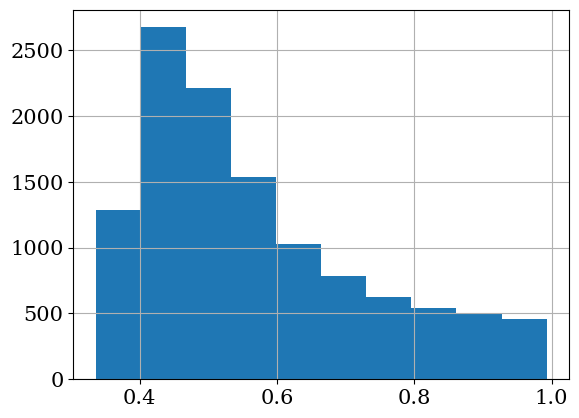

In [61]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see prediction confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. We will try to use Groq's fast model, which is likely to be more accurate given that the model is trained on more data.

In [62]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [63]:
inf_df2.head(1)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",negative,0.809384


# Groq API as Overall Text Sentiment Classifier
Using Groq as an overall sentiment classifier is much better. Unfortunately, it was not able to predict on 11,700 rows in one go even though data was chunked.

In [64]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [65]:
list_df[0].head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",negative,0.809384
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?,negative,0.404206
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?,negative,0.433115
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,iOS 18: The everybody else's features update,positive,0.481576
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,positive,0.622624


In [66]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentiment: negative, neutral or positive.
                Also provide confidence score as a percentage. 
                Output only as a Python string with sentiment and confidence score with comma in between. 
                Example output: neutral, 0.85
                Output needs to be the Python string only. 
                No need for introduction or explanation sentences. 
                Only return: 'neutral, 0.85'
                .
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 1.07 s, sys: 36 ms, total: 1.11 s
Wall time: 2min 41s


In [67]:
groq_sentiment[:10]

['positive, 0.91',
 'neutral, 0.5',
 'positive, 0.72',
 'positive, 0.77',
 'positive, 0.75',
 'negative, 0.85',
 'neutral, 0.8',
 'positive, 0.85',
 'positive, 0.9',
 'positive, 0.9']

In [68]:
list_df[0]['final_text'][:10]

0    Marques for all us Apple users, do you think you could tell Apple to fix the horrible "do you want to open this link in the "x" app" that just loops  to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY
1                                                                                                                                                                                                                                          Can we tag faces with names?
2                                                                                                                                                                                   Will those who do not have the newest iPhones still be able to use Siri without AI?
3                                                                                                                                                                                                               

Groq definitely has better intelligence than HuggingFace's model. Most likely due to model architecture and training data. Really enjoying the accuracy of predictions, ease of API use and last but not least, the speed. 

* [x] add groq predictions to df
* [x] split string of prediction and prediction score into own columns
* [x] depict comparative graph between hf_score and groq_score
* [x] try to loop through predictions for ~11,700 row df

In [69]:
# add 100 predictions to 100-row df

list_df[0]['groq_sentiment'] = groq_sentiment
list_df[0].head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,groq_sentiment
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",negative,0.809384,"positive, 0.91"
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?,negative,0.404206,"neutral, 0.5"
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,Will those who do not have the newest iPhones still be able to use Siri without AI?,negative,0.433115,"positive, 0.72"
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,iOS 18: The everybody else's features update,positive,0.481576,"positive, 0.77"
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,positive,0.622624,"positive, 0.75"


In [70]:
# split string on delimiter comma to create sentiment string column and prediction confidence score column
# cast score column as float

list_df[0][['groq_sentiment', 'groq_score']] = list_df[0]['groq_sentiment'].str.split(',', expand=True)
list_df[0].head(2)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,groq_sentiment,groq_score
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",negative,0.809384,positive,0.91
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,Can we tag faces with names?,negative,0.404206,neutral,0.5


In [71]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    45
neutral     32
negative    23
Name: count, dtype: int64

In [72]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95     18
0.92     10
0.75      9
0.85      8
0.9       7
0.98      7
0.99      5
0.65      4
0.72      4
0.8       3
0.93      2
0.58      2
0.5       2
0.91      2
0.7       1
0.4       1
0.73      1
0.78      1
0.965     1
0.44      1
0.84      1
0.83      1
0.71      1
0.96      1
0.55      1
0.6       1
0.51      1
0.45      1
0.62      1
0.77      1
0.43      1
Name: count, dtype: int64

In [73]:
# Clean up API output
list_df[0]['groq_sentiment'] = list_df[0]['groq_sentiment'].str.lower()

def remove_extra_quotes(col):
    return col.str.replace("'", "")
 
list_df[0]['groq_sentiment'] = remove_extra_quotes(list_df[0]['groq_sentiment'])
list_df[0]['groq_score'] = remove_extra_quotes(list_df[0]['groq_score'])

In [74]:
list_df[0]['groq_sentiment'].value_counts()

groq_sentiment
positive    45
neutral     32
negative    23
Name: count, dtype: int64

In [75]:
list_df[0]['groq_score'].value_counts()

groq_score
0.95     18
0.92     10
0.75      9
0.85      8
0.9       7
0.98      7
0.99      5
0.65      4
0.72      4
0.8       3
0.93      2
0.58      2
0.5       2
0.91      2
0.7       1
0.4       1
0.73      1
0.78      1
0.965     1
0.44      1
0.84      1
0.83      1
0.71      1
0.96      1
0.55      1
0.6       1
0.51      1
0.45      1
0.62      1
0.77      1
0.43      1
Name: count, dtype: int64

In [76]:
# Convert string into float
list_df[0]['groq_score'] = list_df[0]['groq_score'].astype(float)

<Axes: >

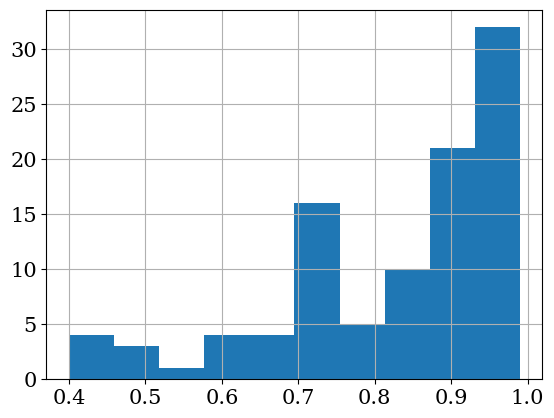

In [77]:
# Let's take a look at Groq's prediction score distribution.
# Hopefully, it is better than 0.4 range which was where HF sentiment hovered.

list_df[0]['groq_score'].hist()

Very nice. Confidence is mostly > 0.9!

____
# Groq at scale unfortunately does not work. 

I tried below algorithm but the output never came out after waiting for 4 hours of run time. This was the predicted computation time because took 2 minutes to do 100 rows of inference.

* [x] Just need to loop through list_df to create 117 diff prediction lists for each 100 block of rows
* [x] add each of the 117 lists to each df 
* [x] concat df's to blank df (11,700 total rows should be final df count)

In [ ]:
# # fxn to get prediction per df with 100 rows only
# def groq_predictions(df):
    
#     #Checking to see if for loop without fxn works
#     groq_sentiment = [] # to store predictions
#     for text in df['final_text']: #using one chunk of 100 rows only, looping through text fed into model
#         chat_completion = client.chat.completions.create( #task performed on each comment
#             messages=[
#                 {
#                     "role": "user",
#                     "content": '''

#                     Please classify the following comment with a sentiment: negative, neutral or positive.
#                     Also provide confidence score as a percentage. 
#                     Output only as a Python string with sentiment and confidence score with comma in between. 
#                     Example output: neutral, 0.85
#                     Output needs to be the Python string only. 
#                     No need for introduction or explanation sentences. 
#                     Only return: 'neutral, 0.85'
#                     .
#                     This is the comment to classify sentiment on:
#                     '''
#                     + text,
#                 }
#             ],
#             model="llama3-8b-8192",
#         )
#         res = chat_completion.choices[0].message.content

#         groq_sentiment.append(res) #adding prediction to list to eventually append to df
    
#     return groq_sentiment

In [ ]:
# # This whole thing will take >~4 hours...added progress bar to keep track

# df0 = pd.DataFrame()

# for df in tqdm_notebook(list_df, desc="PROGRESS"): # this will loop through 117 x 
#     # function to create predictons from 100 row df's final_text col
#     groq_sentiment = groq_predictions(df)

#     # add list to df
#     df['groq_sentiment'] = groq_sentiment

#     # add this to df0
#     df0 = pd.concat([df0, df])

# # output final big df. hopefully rows add up to: 117,000  
# df0.info()

Got this error after trying to do 11,700 predictions in 100-row chunks:

_InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}_

Based on their doc's: 503 Service Unavailable: The server is not ready to handle the request, often due to maintenance or overload. Wait before retrying the request.

After trying one more time, got the below error. 
_InternalServerError: upstream connect error or disconnect/reset before headers. reset reason: connection timeout_

Will just work with Groq's 100 predictions and PyABSA 117 row output. :)
___

## Emotion Classification

In [78]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [79]:
%%time

# Info pg: https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 18min 38s, sys: 4.48 s, total: 18min 42s
Wall time: 9min 24s


,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion
0,@dejayy8992,0,"Marques for all us Apple users, do you think you could tell Apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! Its been years and Apple just refuses to fix it xD. TY",2024-07-13,YouTube,"marques for all us apple users, do you think you could tell apple to fix the horrible ""do you want to open this link in the ""x"" app"" that just loops to the app store even if you have the app installed!! its been years and apple just refuses to fix it xd. ty",negative,0.809384,anger
1,@srmtravel,0,Can we tag faces with names?,2024-07-13,YouTube,can we tag faces with names?,negative,0.404206,anger
2,@matt.rentfro,0,Will those who do not have the newest iPhones still be able to use Siri without AI?,2024-07-13,YouTube,will those who do not have the newest iphones still be able to use siri without ai?,negative,0.433115,joy
3,@tommys_version,0,iOS 18: The everybody else's features update,2024-07-13,YouTube,ios 18: the everybody else's features update,positive,0.481576,joy
4,@jonaspadberg7385,0,The most interesting thing is that Marques has the german railway app on the homescreen of the pixel :D,2024-07-11,YouTube,the most interesting thing is that marques has the german railway app on the homescreen of the pixel :d,positive,0.622624,joy


Emotion classifier is somewhat off, but does help augment HF sentiment classification when both agree and are right in sentiment.

## Sentiment and Emotion over Time

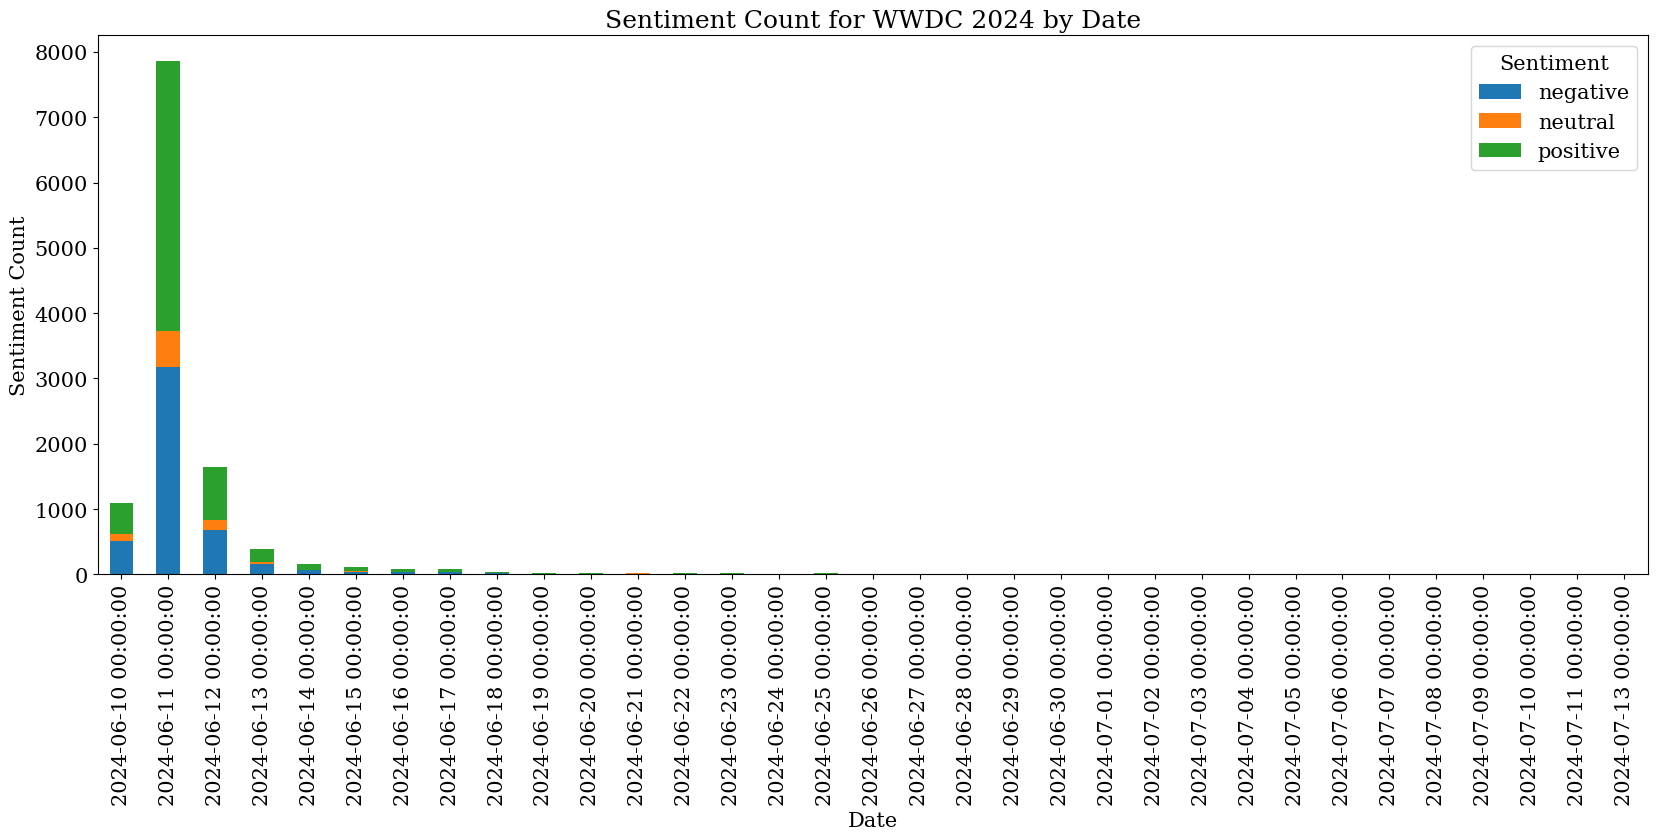

In [80]:
# For YouTube and Reddit users

# Group by hf sentiment label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(20, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

Most comments made on 6.11.24. And there is almost a split in sentiment between positive and negative. Mostly positive across days. Let's take a look at the emotion breakdown. 

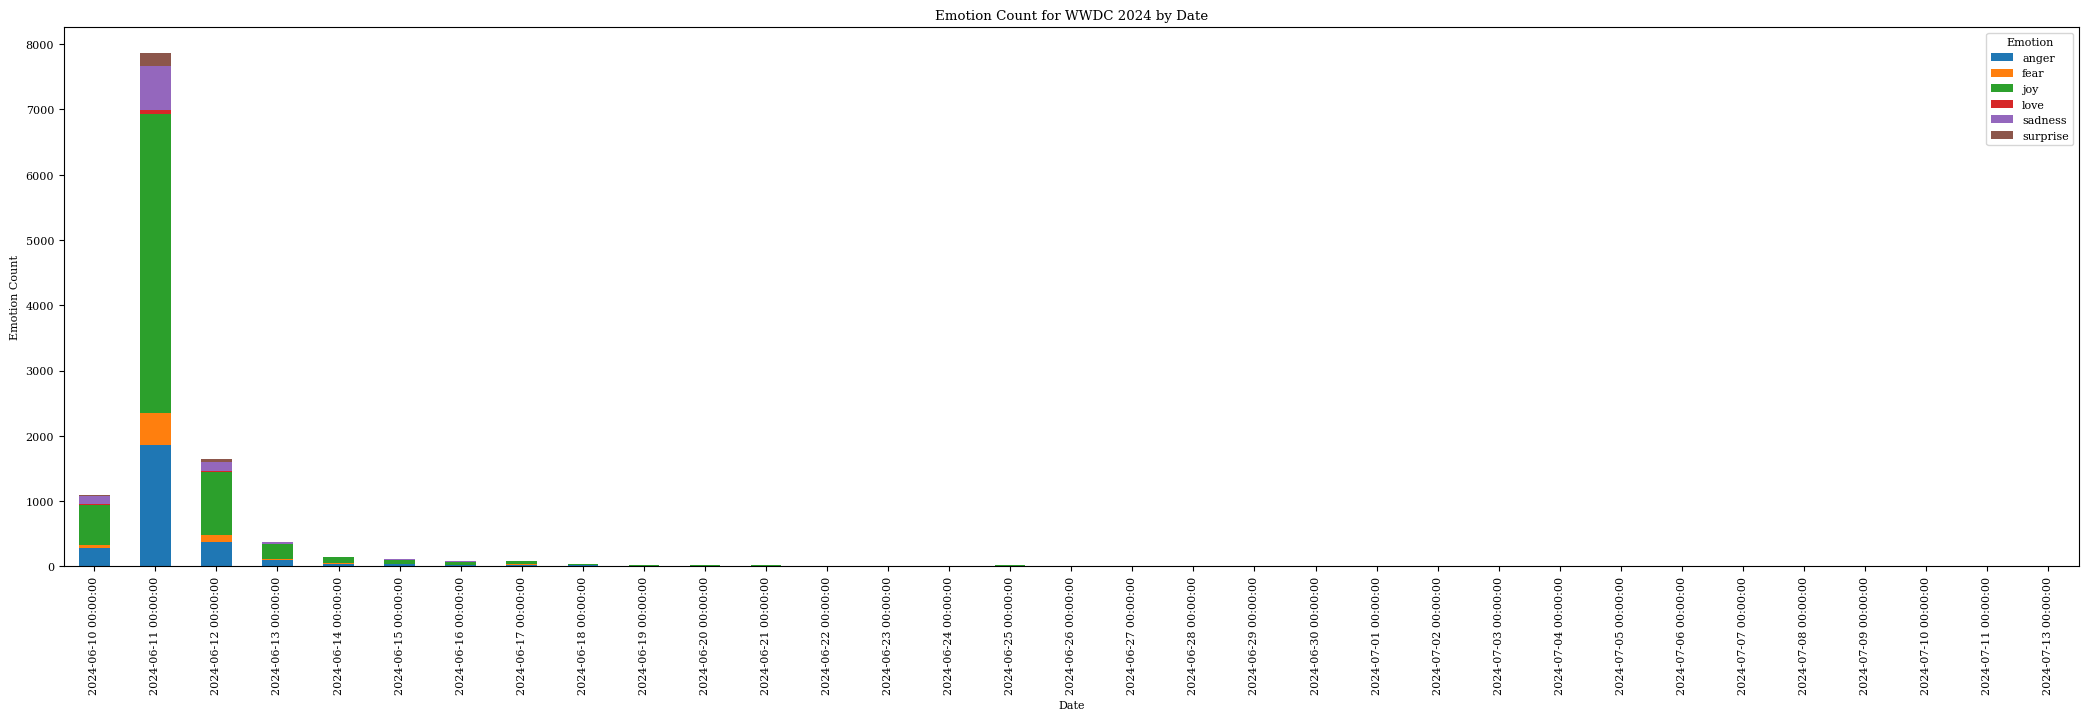

In [112]:
# Group by hf emotion label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=90)
plt.legend(title='Emotion')
plt.show()

With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA)
Trying to get more granular with sentiment analysis. E.g. What particular aspects from comments/features lead to joy/anger?

## Using General Aspect Extractor

In [82]:
# just pick a sample from df to perform general aspect-based sentiment analysis to see its performance
inf_df2_percent = inf_df2.sample(frac=0.01)
inf_df2_percent = inf_df2_percent.reset_index(drop=True)
len(inf_df2_percent)

116

In [84]:
# Let us try HuggingFace model for Aspect Based Sentiment Analysis
# Ref: https://huggingface.co/yangheng/deberta-v3-large-absa-v1.1

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [85]:
%%time

aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

inf_df2_percent['absa_gen'] = inf_df2_percent.apply(lambda row: absa_general(row['final_text']), axis=1)

CPU times: user 34min 1s, sys: 3.28 s, total: 34min 4s
Wall time: 17min 3s


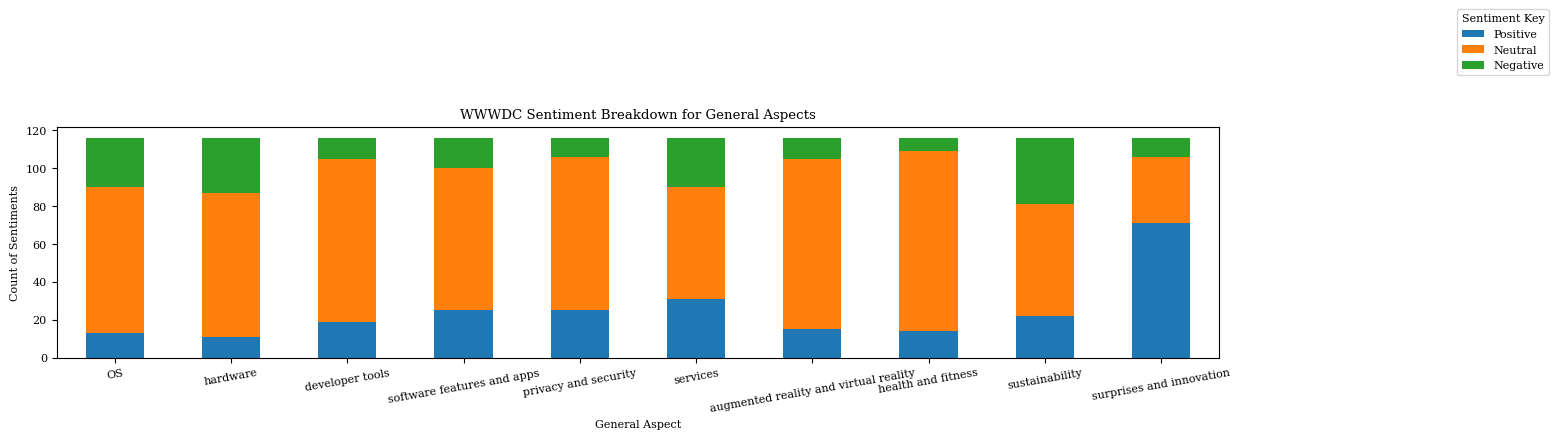

In [87]:
# Extract keys and create new columns
for key in inf_df2_percent['absa_gen'][0].keys():
    inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ["OS", "hardware", "developer tools", "software features and apps", 
           "privacy and security", "services", "augmented reality and virtual reality",
          "health and fitness", "sustainability", "surprises and innovation"]

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = inf_df2_percent[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('WWWDC Sentiment Breakdown for General Aspects')
plt.xlabel('General Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation= 10)
plt.rcParams["figure.figsize"] = (15,3)
plt.rcParams.update({'font.size': 8})


# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.2, 1.2), loc='lower left')

# Adjust the layout to make room for the legend
# plt.tight_layout()

# Show the plot
plt.show()

This is only based on a percentage of the original df - around 117 rows only. The doubtful sentiment classifications and knowing the general sentiment already of commenters' sentiment on specific topics, the model seemed to not have performed well. At least we know now the model's limitations given not that much data it was fed as well as the model most likely not being trained on Conference feedback data. Looking back at the reference page, the training data and fine-tuning data was from feedback from restaurants, tweets, etc, not necessarily new release comments. So the low interpretation quality makes sense.

## Using PyABSA

In [88]:
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-13 20:48:37] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-13 20:48:37] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-13 20:48:37] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-13 20:48:37] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-13 20:48:47] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-13 20:48:47] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-13 20:48:47] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-13 20:48:47] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-13 20:48:47] (2.4.1.post1) model: None
[2024-07-13 20:48:47] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-13 2

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



___
## PyABSA on whole df would take approximately 8 hours to run and possibly cause notebook to crash.

In [ ]:
# create blank df to add subsequent df's to it
# loop through each 117 100-row df's
# add new PyABSA prediction column
# concat all 117 df's together

# df0 = pd.DataFrame()
# for df in tqdm_notebook(list_df, desc="PROGRESS"):
    
#     df['absa_sp'] = df['final_text'].apply(lambda x: absa_sp([x]))
#     df0 = pd.concat([df0, df])
    
# df0.info()

___

# PyABSA on 117 rows of data only

In [89]:
%%time

# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


inf_df2_percent['absa_sp'] = inf_df2_percent['final_text'].apply(lambda x: absa_sp([x]))

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-07-13 20:49:59] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 20:49:59] (2.4.1.post1) Example 0: i shouldn ’ t be surprised but i ’ m very annoyed that my thousands of dollars of apple products , all of which are less than 5 years old , will not run any of the fun new os features
[2024-07-13 20:50:02] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 20:50:02] (2.4.1.post1) Example 0: " type to siri " was always present , since many years .
[2024-07-13 20:50:06] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-13 20:50:06] (2.4.1.post1) Example 0: we were laughing at <jack:Negative Confidence:0.9993> ma 

In [90]:
def aspect(x):
    return list(x.values())

def aspect_sentiment(x):
    return list(x.keys())

In [91]:
inf_df2_percent['aspect'] = inf_df2_percent.apply(lambda row: aspect(row['absa_sp']), axis=1)
inf_df2_percent['aspect'] = inf_df2_percent['aspect'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent.apply(lambda row: aspect_sentiment(row['absa_sp']), axis=1)
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.join('')
inf_df2_percent['aspect_sentiment'] = inf_df2_percent['aspect_sentiment'].str.lower()
inf_df2_percent.drop(columns=['absa_sp'], inplace=True)

In [92]:
inf_df2_percent.head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_gen,...,developer tools,software features and apps,privacy and security,services,augmented reality and virtual reality,health and fitness,sustainability,surprises and innovation,aspect,aspect_sentiment
0,@dr00ku,0,"I shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",2024-06-11,YouTube,"i shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",negative,0.743131,anger,"{'OS': 'Positive', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Positive', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,os features,negative
1,@karthikeshwar,0,"""Type to Siri"" was always present, since many years.",2024-06-11,YouTube,"""type to siri"" was always present, since many years.",positive,0.398852,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Positive', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Positive,,
2,@dice5248,1102,We were laughing at Jack Ma but I always believed in Alibaba Intelligence.,2024-06-11,YouTube,we were laughing at jack ma but i always believed in alibaba intelligence.,negative,0.348300,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,jack,negative
3,@warriorwayp4480,0,Apple just renamed AI ( APPLE 🍎🍎 INTELLIGENCE 😂😂),2024-06-11,YouTube,apple just renamed ai ( apple 🍎🍎 intelligence 😂😂),positive,0.463970,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,apple,neutral
4,@bryandebourbon,0,tap to pay between iphone users was pretty big for me,2024-06-11,YouTube,tap to pay between iphone users was pretty big for me,positive,0.681005,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,iphone,neutral


### Auditing PyABSA Inference

In [93]:
inf_df2_percent.head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_gen,...,developer tools,software features and apps,privacy and security,services,augmented reality and virtual reality,health and fitness,sustainability,surprises and innovation,aspect,aspect_sentiment
0,@dr00ku,0,"I shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",2024-06-11,YouTube,"i shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",negative,0.743131,anger,"{'OS': 'Positive', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Positive', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,os features,negative
1,@karthikeshwar,0,"""Type to Siri"" was always present, since many years.",2024-06-11,YouTube,"""type to siri"" was always present, since many years.",positive,0.398852,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Positive', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Positive,,
2,@dice5248,1102,We were laughing at Jack Ma but I always believed in Alibaba Intelligence.,2024-06-11,YouTube,we were laughing at jack ma but i always believed in alibaba intelligence.,negative,0.348300,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,jack,negative
3,@warriorwayp4480,0,Apple just renamed AI ( APPLE 🍎🍎 INTELLIGENCE 😂😂),2024-06-11,YouTube,apple just renamed ai ( apple 🍎🍎 intelligence 😂😂),positive,0.463970,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,apple,neutral
4,@bryandebourbon,0,tap to pay between iphone users was pretty big for me,2024-06-11,YouTube,tap to pay between iphone users was pretty big for me,positive,0.681005,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,iphone,neutral


In [94]:
inf_df2_percent.tail()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_gen,...,developer tools,software features and apps,privacy and security,services,augmented reality and virtual reality,health and fitness,sustainability,surprises and innovation,aspect,aspect_sentiment
111,@abhijeetkumarsingh8670,0,what's special in calculator app if you can do all that in iPhone calculator app too !!! I mean weren't giving it in iPad coz they wanted to give something special according to iPad or specifically for iPad like the Craig said in your interview but if i can perform all that even on iPhone then why wait for so long,2024-06-12,YouTube,what's special in calculator app if you can do all that in iphone calculator app too !!! i mean weren't giving it in ipad coz they wanted to give something special according to ipad or specifically for ipad like the craig said in your interview but if i can perform all that even on iphone then why wait for so long,negative,0.416865,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}",...,Neutral,Neutral,Neutral,Negative,Neutral,Neutral,Negative,Neutral,iphone,neutral
112,@rmp5s,0,I really wish apple wasn't such a shit company. I'm 100% their target demographic.,2024-06-11,YouTube,i really wish apple wasn't such a shit company. i'm 100% their target demographic.,negative,0.536509,joy,"{'OS': 'Neutral', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Negative', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Negative', 'surprises and innovation': 'Neutral'}",...,Neutral,Neutral,Neutral,Negative,Neutral,Neutral,Negative,Neutral,apple,negative
113,@dwights1024,19,Incredible we can move our icons anywhere how revolutionary,2024-06-10,YouTube,incredible we can move our icons anywhere how revolutionary,positive,0.607711,joy,"{'OS': 'Positive', 'hardware': 'Positive', 'developer tools': 'Positive', 'software features and apps': 'Positive', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Positive', 'health and fitness': 'Positive', 'sustainability': 'Positive', 'surprises and innovation': 'Positive'}",...,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,icons,positive
114,@zorbageekman2761,0,"AI will replace humans, likely in the not to distant future, but truly apple users will be the first to be superseded given they are truly societies low hanging fruit!",2024-06-11,YouTube,"ai will replace humans, likely in the not to distant future, but truly apple users will be the first to be superseded given they are truly societies low hanging fruit!",negative,0.518936,sadness,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,fruit,negative
115,Gamesus10,1,Right but how would it compare for laptop users?,2024-06-10,Reddit,right but how would it compare for laptop users?,neutral,0.351998,anger,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Positive', 'services': 'Positive', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Positive', 'sustainability': 'Positive', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Positive,Positi

Small sample, but PyABSA is somewhat more accurate than emotion classifier and much better than Hugging Face's sentiment classifier. Pretty spot-on with most aspects though. Groq wins! :)

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

## POC:

In [95]:
content = '''
apple intelligence coping android and samsung ai. very intelligent. 2.0update. just go android 
and youll get 100% custumization not just 10% with iphone. in android samsung tablet s9ultra 
we have myscript calculator app and does very advanced calculations with samsung s pen does all 
your math homework and we had this app for 7yrs ago so bravo now u have a calculator app on ipad m4. 
man apple users get so exited for stuff we had for years on android. exept wen apple users always 
think oh apple does it better yea right... no brain.
'''

doc = nlp(content)

for ent in doc.ents:
	print(ent.text, ent.start_char, ent.end_char, ent.label_)

samsung 39 46 ORG
100% 111 115 PERCENT
just 10% 134 142 PERCENT
android samsung 159 174 ORG
s9ultra 182 189 LAW
samsung s pen 264 277 PERSON
7yrs ago 331 339 DATE
m4 385 387 GPE
years 441 446 DATE
wen apple 465 474 PERSON


In [96]:
displacy.render(doc, style="ent")

/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [97]:
entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
ner_df

,text,type,lemma
0,samsung,ORG,samsung
1,100%,PERCENT,100%
2,just 10%,PERCENT,just 10%
3,android samsung,ORG,android samsung
4,s9ultra,LAW,s9ultra
5,samsung s pen,PERSON,samsung s pen
6,7yrs ago,DATE,7yr ago
7,m4,GPE,m4
8,years,DATE,year
9,wen apple,PERSON,wen apple


The type and lemma are rough. There is better output from Aspect Based Sentiment Analysis where aspects are drawn out. And sentiment is tied to it.

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: number likes, sentiment/emotion 
* compare YouTube and Reddit comments across like count (popularity) and overall sentiment (choose more accurate classifier: absa) and overall emotion

* First pass: to see how Radar Graph works
1. [x] preview like count across YouTube and Reddit
1. [x] pick best overall sentiment classifier (Groq) FOR NOW, PyABSA is more accurate than emotion classifier on overall comment
1. [x] will need to transform sentiment classification into grades
1. [x] create Radar graph to see how each social media platforms' sentiment compares across different metrics

* Second pass: Examine most talked about releases and sentiment tied to it
1. [x] grab data from absa sp
1. [x] do an aggregation with aspect for sentiment and popularity (like rating, num reviews)

In [98]:
inf_df2_percent.head(1)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_gen,...,developer tools,software features and apps,privacy and security,services,augmented reality and virtual reality,health and fitness,sustainability,surprises and innovation,aspect,aspect_sentiment
0,@dr00ku,0,"I shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",2024-06-11,YouTube,"i shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",negative,0.743131,anger,"{'OS': 'Positive', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Positive', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Positive,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,os features,negative


In [99]:
query = """
select app
, sum(like_count) as total_liked_comments
from inf_df2_percent
group by 1
"""

duckdb.query(query).df()

,app,total_liked_comments
0,YouTube,1951.0
1,Reddit,188.0


A lot more activity on YouTube

In [100]:
query = """
select app 
, hf_emotion
, count(hf_emotion) as total_emotion_count
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

,app,hf_emotion,total_emotion_count
0,YouTube,joy,52
1,YouTube,anger,25
2,YouTube,fear,10
3,YouTube,sadness,9
4,Reddit,joy,8
5,Reddit,anger,4
6,Reddit,sadness,2
7,YouTube,love,2
8,YouTube,surprise,2
9,Reddit,fear,1


Across both social media platforms, comments are dominated by joy then anger.

In [101]:
query = """
select app
, aspect
, count(aspect) as total_aspects
from inf_df2_percent
group by 1,2
order by 3 desc
"""

duckdb.query(query).df()

,app,aspect,total_aspects
0,YouTube,,27
1,YouTube,apple,12
2,YouTube,iphone,11
3,Reddit,,7
4,YouTube,ipad,4
5,YouTube,ios,3
6,YouTube,notes,3
7,YouTube,iphones,2
8,YouTube,features,2
9,Reddit,apple,2


A lot of comments had unknown sentiment, which is good to know. With comments that were easily classified though, PyABSA produced negative for YouTube's top sentiment and neutral for Reddit's top sentiment.

In [102]:
# Creating grades from sentiments - only using emotion, and aspect based sentiment classification

query = """
select *
, case when hf_emotion IN ('anger', 'fear') then 1
when hf_emotion IN ('sadness', 'surprise') then 2
when hf_emotion IN ('joy', 'love') then 3
else 0
end as emotion_grade
, case when aspect_sentiment = 'negative' then 1
when aspect_sentiment = 'neutral' then 2
when aspect_sentiment = 'positive' then 3
else 0
end as aspect_sentiment_grade
from inf_df2_percent
"""

inf_df2_percent_grades = duckdb.query(query).df()
inf_df2_percent_grades.head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_gen,...,privacy and security,services,augmented reality and virtual reality,health and fitness,sustainability,surprises and innovation,aspect,aspect_sentiment,emotion_grade,aspect_sentiment_grade
0,@dr00ku,0,"I shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",2024-06-11,YouTube,"i shouldn’t be surprised but i’m very annoyed that my thousands of dollars of apple products, all of which are less than 5 years old, will not run any of the fun new os features",negative,0.743131,anger,"{'OS': 'Positive', 'hardware': 'Negative', 'developer tools': 'Neutral', 'software features and apps': 'Positive', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,os features,negative,1,1
1,@karthikeshwar,0,"""Type to Siri"" was always present, since many years.",2024-06-11,YouTube,"""type to siri"" was always present, since many years.",positive,0.398852,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Positive', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Positive,Neutral,Neutral,Neutral,Neutral,Positive,,,3,0
2,@dice5248,1102,We were laughing at Jack Ma but I always believed in Alibaba Intelligence.,2024-06-11,YouTube,we were laughing at jack ma but i always believed in alibaba intelligence.,negative,0.348300,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Neutral'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,jack,negative,3,1
3,@warriorwayp4480,0,Apple just renamed AI ( APPLE 🍎🍎 INTELLIGENCE 😂😂),2024-06-11,YouTube,apple just renamed ai ( apple 🍎🍎 intelligence 😂😂),positive,0.463970,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,apple,neutral,3,2
4,@bryandebourbon,0,tap to pay between iphone users was pretty big for me,2024-06-11,YouTube,tap to pay between iphone users was pretty big for me,positive,0.681005,joy,"{'OS': 'Neutral', 'hardware': 'Neutral', 'developer tools': 'Neutral', 'software features and apps': 'Neutral', 'privacy and security': 'Neutral', 'services': 'Neutral', 'augmented reality and virtual reality': 'Neutral', 'health and fitness': 'Neutral', 'sustainability': 'Neutral', 'surprises and innovation': 'Positive'}",...,Neutral,Neutral,Neutral,Neutral,Neutral,Positive,iphone,neutral,3,2


In [103]:
# get relevant columns (app, num likes, emotion_grade, aspect_sentiment_grade) and set app as index

query = """
select app
, round(avg(like_count)) as avg_like_count
, round(avg(emotion_grade)) as avg_emotion
, round(avg(aspect_sentiment_grade)) as avg_aspect_sentiment
from inf_df2_percent_grades
group by 1
"""

radar_df = duckdb.query(query).df()

# Set app as index
radar_df.set_index('app', inplace=True)
radar_df

,avg_like_count,avg_emotion,avg_aspect_sentiment
app,,,
Reddit,12.0,2.0,1.0
YouTube,20.0,2.0,1.0


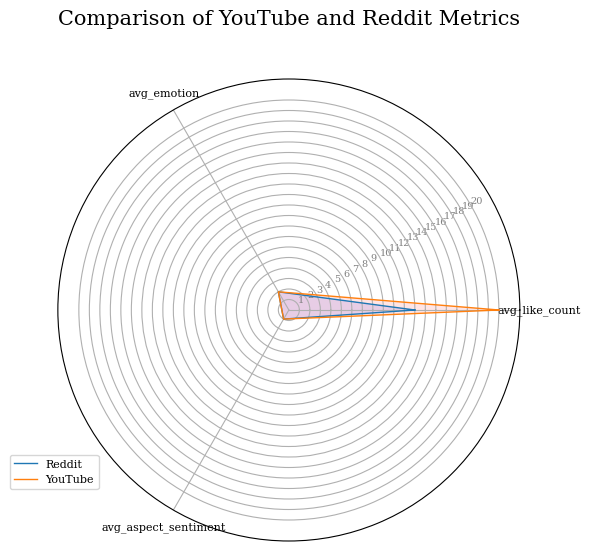

In [108]:
# Data preparation
labels = list(radar_df)
stats_reddit = radar_df.loc['Reddit'].tolist()
stats_youtube = radar_df.loc['YouTube'].tolist()

# Completing the loop
stats_reddit += stats_reddit[:1]
stats_youtube += stats_youtube[:1]

# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], labels)

# Draw y-labels
ax.set_rlabel_position(30)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
           ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"], 
           color="grey", size=7) #this may need to be generarlized due to hard-coding axis for metrics
plt.ylim(0, 22)

# Plot data
ax.plot(angles, stats_reddit, linewidth=1, linestyle='solid', label='Reddit')
ax.fill(angles, stats_reddit, 'b', alpha=0.1)

ax.plot(angles, stats_youtube, linewidth=1, linestyle='solid', label='YouTube')
ax.fill(angles, stats_youtube, 'r', alpha=0.1)

# Add legend
plt.legend(loc='lower right', bbox_to_anchor=(0.1, 0.1))

# Title
plt.title('Comparison of YouTube and Reddit Metrics', size=15, color='black', y=1.1)

# Show plot
plt.show()

Based on this, we see that YouTube wins over Reddit with popularity votes. Would be nice to see what exactly are  the most popular comments talking about.

# Most popular topics and emotion sentiment across YouTube and Reddit

In [113]:
query = """
select case when aspect IN ('iphone', 'iphones') then 'iphone' else aspect end as aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
"""

duckdb.query(query).df()

,aspect,total_occurence
0,iphone,14
1,apple,14
2,ipad,4
3,notes,3
4,ios,3
5,features,2
6,app,2
7,android,2
8,tech,1
9,os features,1


We can see here that past the high-level topic of apple, most talked about WWDC topics were iphone, iPad and app's in general. Given the long tail, there needs to be more data. 

In [116]:
# Overall sentiment of most talked about topics from WWDC

query = """

with cte as (
select case when aspect IN ('iphone', 'iphones') then 'iphone' else aspect end as aspect
, count(*) total_occurence
from inf_df2_percent
where aspect_sentiment NOT IN ('','"')
group by 1
order by 2 desc
)

select aspect
, aspect_sentiment
from inf_df2_percent
where aspect in (select aspect from cte limit 8) 
"""

inf_df2_percent_as = duckdb.query(query).df()
inf_df2_percent_as

,aspect,aspect_sentiment
0,apple,neutral
1,iphone,neutral
2,apple,negative
3,apple,neutral
4,apple,positive
5,apple,negative
6,apple,neutral
7,notes,negative
8,apple,positive
9,ios,negative


In [117]:
# Create the sunburst chart
fig = px.sunburst(
    inf_df2_percent_as,
    path=['aspect', 'aspect_sentiment'],
    color='aspect_sentiment',
    color_discrete_map={'positive':'green', 'neutral':'grey', 'negative':'red'},
    title='Sentiment Analysis of Most Talked About Topics'
)

# Show the plot
fig.show()

At the center, we can see the most talked about topics across YouTube and Reddit. The outer layer shows the different sentiments per topic. iOS and their competitor, Samsung had negative sentiment mostly tied to it. However, things looked good with iPad only (most likely due to the impressive Calculator app). There was positive sentiment for apple, but it was not the dominant emotion. 

It looks like from the WWDC conference, iphone, iPad, iOS, android/Samsung (notes), app and features were the most talked about topics. Looks like Apple needs to work on their reputation even after catch up with AI frontier.